# Group Assignment (Group 15) — Big Data
### By Matteo Ballegeer, Yaël De Rocker, Wannes Janssens, Julian Peire, Tom Willemen
#### Ghent University, Belgium
### -------------------------------------------------------------------------------------------------------------------------------------------------------------
# Feature Engineering

## 1.  Initialize Spark Environment

In [4]:
# import findspark
import findspark
# initialize findspark with spark directory
import pyspark
# create spark context
user="Matteo"
if user =="Tom":
    findspark.init("C:\Spark\spark-3.4.1-bin-hadoop3")
    config = pyspark.SparkConf().setAll([('spark.executor.memory', '8g'), 
                                        ('spark.executor.cores', '10'), 
                                        ('spark.cores.max', '8'), 
                                        ('spark.driver.memory','16g'),
                                        ('spark.network.timeout', '3600s'),
                                        ("spark.executor.heartbeatInterval", "3000s")])   # Increased the network timeout 
if user =="Matteo":
    findspark.init("C:\Spark\spark-3.5.0-bin-hadoop3")
    config = pyspark.SparkConf().setAll([
        ('spark.executor.memory', '8g'),
        ('spark.executor.cores', '4'),
        ('spark.cores.max', '4'),
        ("spark.sql.shuffle.partitions", "4"),
        ('spark.driver.memory', '8g'),
        ("spark.executor.instances", "4"),
        ('spark.network.timeout', '3600s'),
    ])
    config.setMaster("local[6]")
if user == "Julian":
    findspark.init('C:\\Users\\jaron\\Spark\\spark-3.5.0-bin-hadoop3')
    config = pyspark.SparkConf().setAll([('spark.executor.memory', '8g'), 
                                            ('spark.executor.cores', '8'), 
                                            ('spark.cores.max', '7'), 
                                            ('spark.driver.memory','16g'),
                                            ('spark.network.timeout', '3600s'),
                                            ("spark.executor.heartbeatInterval", "3000s")])   # Increased the network timeout
    config.setMaster("local[8]")    
if user == "Wannes":
    findspark.init("C:\Spark\spark-3.5.0-bin-hadoop3")
    config = pyspark.SparkConf().setAll([
        ("spark.executor.memory", "8g"),
        ("spark.executor.cores", "8"),
        ('spark.driver.memory', '8g'),
        ('spark.cores.max', '8')
    ]) 
    config.setMaster("local[4]")

sc = pyspark.SparkContext(conf=config)  
# create spark session 
spark = pyspark.sql.SparkSession(sc)

In [5]:
# inspect spark session
spark

## 2. Import packages and definition of UDFs

In [6]:
# import packages

## General Packages
import os 
import json
import lzma
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import re
from tqdm import tqdm
from sklearn.cluster import KMeans

## NLP and Sentiment Analysis
from string import punctuation
from nltk.corpus import stopwords
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import emoji
import spacy
from spacy import displacy

## Pyspark 
import pyspark.sql.functions as F
from pyspark.sql.functions import col, concat_ws, when, hour, month, to_timestamp, expr, sum, isnan, regexp_replace, lower, explode
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf 
from pyspark.sql.types import *
from pyspark.sql.window import Window

## Image analysis
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import cv2
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import mtcnn
import imutils
from mtcnn import MTCNN
import pytesseract

In [7]:
# Define functions
## Define puncutation and stopwords
PUNCTUATION = [char for char in punctuation if char not in ["!", "@", "#"]]
STOPWORDS = stopwords.words("english")

## Define function to remove punctuation
def remove_punct(text):
    text = "".join([char for char in text if char not in PUNCTUATION])
    return(text)

## Define function to remove stopwords
def remove_stops(text_tokenized):
    text_tokenized = [word for word in text_tokenized if word not in STOPWORDS]
    return(text_tokenized)

def clean_text_udf(text):
    # Define regular expressions
    remove_hashtags_urls_regex = "(#\\w+\\s*)|(https?://\\S+\\s*)"
    punctuation_regex = "[\W_]"
    remove_rn_regex = "[\r\n]"
    remove_single_characters_regex = "\\b\\w\\b"

    # Apply transformations to clean the text
    cleaned_text = re.sub(remove_hashtags_urls_regex, "", text)
    cleaned_text = re.sub(punctuation_regex, " ", cleaned_text)
    cleaned_text = re.sub(remove_rn_regex, "", cleaned_text)
    cleaned_text = cleaned_text.lower()
    cleaned_text = re.sub(remove_single_characters_regex, "", cleaned_text)

    return cleaned_text

## Define function to count hashtags
def get_hashtags(tokenized_text):
    counter = 0
    for word in tokenized_text:
        if "#" in word:
            counter += 1
    return(counter)

## Define function to count tags
def get_tags(tokenized_text):
    counter = 0
    for word in tokenized_text:
        if "@" in word:
            counter += 1
    return(counter)

## Define function to count exclamation marks
def get_exclamation_marks(tokenized_text):
    counter = 0
    for word in tokenized_text:
        if "!" in word:
            counter += 1
    return(counter)

## Define function to count exclamation marks
def get_question_marks(tokenized_text):
    counter = 0
    for word in tokenized_text:
        if "?" in word:
            counter += 1
    return(counter)

## Define function to check if a caption contains an event
def contains_event(tokenized_text):
    event_synonyms = ['event', 'action', 'promo','lhcityofthemonth', 'oktoberfest', 'traveltuesday', 'cityofthemonth', 'photofriday', 'wingwednesday'] 
    contains = False
    for word in tokenized_text:
        if word.lower() in event_synonyms:
            contains = True
    return contains


## Define function to check if @ is present in text
def get_at(text):
    if "@" in text:
        return(1)
    else:
        return(0)

## Define function to decompress xz file and save as .json
def decompress_xz_file(f_path):
    # define new name
    new_path = f_path.replace(".xz", "")

    # save decompressed file
    with open(new_path, "w") as f:
        json.dump(json.load(lzma.open(f_path)), f)
        
## Define the function to extract the sentiment
def get_sentiment(sentence):
    # initialize sentiment analyzer
    sid_obj = SentimentIntensityAnalyzer()
    # get sentiment dict
    sentiment_dict = sid_obj.polarity_scores(sentence)
    # get compound sentiment score
    pos_sentiment = sentiment_dict["compound"]
    # return compound sentiment score
    return(pos_sentiment)

## Define function to get subjectivity score of text document
def get_subjectivity(row):
    textBlob_review = TextBlob(row)
    return textBlob_review.sentiment[1]

## Define function to check if a caption contains a link
def contains_link(text):
    # Regular expression to match links
    link_pattern = re.compile(r'https?://|www\.|bit\.ly|\.com|\.net|\.org|\.edu')
    # Check if the text contains a link
    return bool(re.search(link_pattern, text))

# Function to create DataFrame from file paths
def create_dataframe_from_paths(paths):
    schema = StructType([StructField("path", StringType(), True)])
    data = [(path,) for path in paths]
    return spark.createDataFrame(data, schema)

NER = spacy.load("en_core_web_sm")
def NER_city(text, city_list):
    entities = NER(text)
    lower_city_list = [city.lower() for city in city_list]
    for entity in entities.ents:
        if entity.label_ == "GPE" and entity.text.lower() in lower_city_list:
            return True
    return False

# Create an instance of MTCNN
detector = MTCNN()

def count_faces_mtcnn(image_path):
    # Read the image
    image = cv2.imread(image_path)
    
    # If image is not loaded, return 0
    if image is None:
        return 0

    # Convert the image to RGB
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Detect faces
    faces = detector.detect_faces(image_rgb)

    # Return the number of faces
    return len(faces)

# Function that looks for images with text and detects the text
def process_text_image_udf(path):
    img = cv2.imread(path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # Adding custom options
    pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'
    str = pytesseract.image_to_string(img_rgb)
    return str


## UDF to check colorfulness of an image 
def image_colorfulness(image_path):
    # load the image, resize it (to speed up computation), and
    # compute the colorfulness metric for the image
    image = cv2.imread(image_path)
     # Check if the image is loaded successfully
    if image is None:
        # Handle the error, for example, by returning a default value or logging an error
        return float('nan')  # Return NaN or some other indicator of failure
    image = imutils.resize(image, width=250)    
    # split the image into its respective RGB components
    (B, G, R) = cv2.split(image.astype("float"))
    # compute rg = R - G
    rg = np.absolute(R - G)
    # compute yb = 0.5 * (R + G) - B
    yb = np.absolute(0.5 * (R + G) - B)
    # compute the mean and standard deviation of both `rg` and `yb`
    (rbMean, rbStd) = (np.mean(rg), np.std(rg))
    (ybMean, ybStd) = (np.mean(yb), np.std(yb))
    # combine the mean and standard deviations
    stdRoot = np.sqrt((rbStd ** 2) + (ybStd ** 2))
    meanRoot = np.sqrt((rbMean ** 2) + (ybMean ** 2))
    # derive the "colorfulness" metric and return it
    return float(round(stdRoot + (0.3 * meanRoot),2))

## UDF to count emojis in the caption text
def count_emojis(text):
    if text is None:
        return 0
    return emoji.emoji_count(text)
# Register UDF to use in DataFrame
count_emojis_udf = F.udf(count_emojis, IntegerType())

## UDF to extract emoji's used
def extract_emojis(text):
    if text is None:
        return []
    return emoji.distinct_emoji_list(text)

# create UDF to extract date 
def extract_date(post_id):
    return post_id.split("_")[0]

## Register functions as udf
extract_emojis_udf = F.udf(extract_emojis, ArrayType(StringType()))
extract_date = F.udf(extract_date, StringType())
count_emojis_udf = F.udf(count_emojis, IntegerType())
remove_punct_UDF = F.udf(remove_punct, StringType())
remove_stops_UDF = F.udf(remove_stops, ArrayType(StringType()))
clean_text_UDF = F.udf(clean_text_udf, StringType())
get_hashtags_udf = F.udf(get_hashtags, IntegerType())
get_tags_udf = F.udf(get_tags, IntegerType())
get_exclamation_marks_udf = F.udf(get_exclamation_marks, IntegerType())
get_question_marks_udf = F.udf(get_question_marks, IntegerType())
get_sentiment_udf = F.udf(get_sentiment, DoubleType())
contains_event_udf = F.udf(contains_event, BooleanType())
get_at_udf = F.udf(f=get_at, returnType=IntegerType())
contains_link_udf = F.udf(contains_link, returnType=BooleanType())
NER_city_udf = F.udf(NER_city, BooleanType())
get_subjectivity_udf = F.udf(get_subjectivity, DoubleType())
colorfulness_udf = udf(image_colorfulness, DoubleType())
count_faces_udf = udf(count_faces_mtcnn, IntegerType())
process_text_image = udf(process_text_image_udf, StringType())

## 3. Preprocess & Load Data

In [6]:
# Define data dir for brand owned posts 
luf_dir = "../data/lufthansa_usa/"

### 3.1. Text Files

In [53]:
# Get all the names and paths of the text files

## Brand owned posts
text_names_luf = [obs for obs in os.listdir(luf_dir) if ".txt" in obs]
text_paths_luf = [os.path.join(luf_dir, obs) for obs in text_names_luf]

## Calculate and print the counts
print("Amount of text files for Lufthansa brand owned posts :", len(text_paths_luf))

Amount of text files for Lufthansa brand owned posts : 1880


In [64]:
# Read captions brand post and store features
text_df_luf = spark.read.text(text_paths_luf, wholetext=True) \
                                 .withColumn("file_path", F.input_file_name()) \
                                 .withColumnRenamed("value", "text") \
                                 .withColumn("post_id", F.regexp_extract(F.col("file_path"), r'(\d{4}-\d{2}-\d{2}_\d{2}-\d{2}-\d{2}_UTC)', 1))\
                                 .withColumn("text_lower", F.lower("text")) \
                                 .withColumn("text_cleaned", remove_punct_UDF("text_lower")) \
                                 .withColumn("text_tokenized", F.split("text_cleaned", " ")) \
                                 .withColumn("text_tokenized_no_stops", remove_stops_UDF("text_tokenized")) \
                                 .drop("text_tokenized") \
                                 .drop("file_path")\
                                 .cache()
text_df_luf=text_df_luf.withColumn("num_words", F.size("text_tokenized_no_stops")) \
                                 .withColumn("num_hashtags", get_hashtags_udf("text_tokenized_no_stops")) \
                                 .withColumn("num_tags", get_tags_udf("text_tokenized_no_stops")) \
                                 .cache()
text_df_luf=text_df_luf.withColumn("num_exclamation_marks", get_exclamation_marks_udf("text_tokenized_no_stops")) \
                                 .withColumn("num_question_marks", get_question_marks_udf("text_tokenized_no_stops")) \
                                 .cache()
text_df_luf=text_df_luf.withColumn('is_event', contains_event_udf("text_tokenized_no_stops")) \
                                 .drop("text_tokenized_no_stops")\
                                 .withColumn("sentiment", get_sentiment_udf("text")) \
                                 .withColumn("subjectivity", get_subjectivity_udf("text"))\
                                 .cache()
text_df_luf=text_df_luf.withColumn("contains_link", contains_link_udf("text")) \
                                 .withColumn("at_in_text", get_at_udf(F.col("text"))) \
                                 .withColumn("nr_emojis", count_emojis_udf("text")) \
                                 .cache()
## Now properly clean tokenized to remove hashtags and improper strings so these are not counted twice 
text_df_luf= text_df_luf.withColumn("text_cleaner", clean_text_UDF("text_cleaned")) \
                                 .withColumn("text_tokenized", F.split("text_cleaner", " ")) \
                                 .withColumn("text_tokenized_no_stops", remove_stops_UDF("text_tokenized")) \
                                 .drop("text_cleaned") \
                                 .drop("text_lower") \
                                 .drop("text_cleaner") \
                                 .drop("text_tokenized") \
                                 .filter("num_words > 0") \
                                 .cache()
text_df_luf.show(5)

+--------------------+--------------------+---------+------------+--------+---------------------+------------------+--------+---------+-------------------+-------------+----------+---------+-----------------------+
|                text|             post_id|num_words|num_hashtags|num_tags|num_exclamation_marks|num_question_marks|is_event|sentiment|       subjectivity|contains_link|at_in_text|nr_emojis|text_tokenized_no_stops|
+--------------------+--------------------+---------+------------+--------+---------------------+------------------+--------+---------+-------------------+-------------+----------+---------+-----------------------+
|We are doing our ...|2020-03-25_15-10-...|      133|           1|       0|                    0|                 0|   false|   0.9856| 0.5175170068027212|         true|         0|        0|   [best, best, day,...|
|Upon ascending ab...|2017-03-03_22-49-...|       89|           2|       0|                    0|                 0|   false|   0.7096|0.459

Since this "extra" cleaned tokenized text was conceptualised when all our notebooks already had a load file (where order of columns is important), we reorder the dataframe here to align with our other notebooks (so no errors are made).

In [66]:
text_df_luf = text_df_luf.select(
    "text",
    "text_tokenized_no_stops",
    "post_id",
    "num_words",
    "num_hashtags",
    "num_tags",
    "num_exclamation_marks",
    "num_question_marks",
    "is_event",
    "sentiment",
    "subjectivity",
    "contains_link",
    "at_in_text",
    "nr_emojis")

### 3.2. Comments

In [10]:
# Get all the names and paths of the comment files
# Brand owned posts
comment_names_luf = [obs for obs in os.listdir(luf_dir) if "_comments.json" in obs]
comment_paths_luf = [os.path.join(luf_dir, obs) for obs in comment_names_luf]

In [11]:
# Calculate and print the counts
print("Amount of text files for Lufthansa brand owned posts :", len(comment_paths_luf))

Amount of text files for Lufthansa brand owned posts : 1771


In [22]:
# Read Json file brand post comments and store num_comments
comment_df_luf = spark.read.json(comment_paths_luf, multiLine=True) \
                                        .withColumn("file_path", F.input_file_name()) \
                                        .withColumn("post_id", F.regexp_extract(F.col("file_path"), r'(\d{4}-\d{2}-\d{2}_\d{2}-\d{2}-\d{2}_UTC)', 1))\
                                        .groupBy("post_id") \
                                        .agg(                                  
                                    F.count(F.col("post_id")).alias("num_comments"),)


### 3.3. Post Info

In [20]:
# Get all the names of the brand post info files 
post_info_names_luf = [obs for obs in os.listdir(luf_dir) if "UTC.json.xz" in obs]
post_info_paths_luf = [os.path.join(luf_dir, obs) for obs in post_info_names_luf]

In [21]:
# Decompress and save all xz files as json files
for f in post_info_paths_luf:
    decompress_xz_file(f)

In [22]:
# Get all the paths of the decompressed comment files
post_info_paths_luf = [os.path.join(luf_dir, obs).replace(".xz", "") for obs in post_info_names_luf]
# load decompressed post info files
likes_df_luf = spark.read.json(post_info_paths_luf, multiLine=True)

In [23]:
# Add file path as a new column
likes_df_luf= likes_df_luf.withColumn("file_path", F.input_file_name())
# Extract post id from file path and add as new column
likes_df_luf = likes_df_luf.withColumn("post_id", F.regexp_extract(str=likes_df_luf.file_path, pattern="(lufthansa_usa/)(.*)(.json)", idx=2))
# Drop file path column
likes_df_luf = likes_df_luf.drop("file_path")

In [24]:
# Extract data from likes_df
likes_df_luf = likes_df_luf.select(F.col("node.edge_media_preview_like.count").alias("num_likes"),
                                 F.col("node.taken_at_timestamp").alias("unixtime"),
                                 F.get_json_object("node.location.address_json", "$.city_name").alias("city"),
                                 F.get_json_object("node.location.address_json", "$.country_code").alias("country"),
                                 F.col("node.location.address_json").alias("location"),
                                 F.col("node.is_ad"),
                                 F.col("node.is_video"),
                                 F.col("node.dimensions.height").alias("height"),
                                 F.col("node.dimensions.width").alias("width"),
                                 F.col("post_id"), 
                                 F.col("node.edge_sidecar_to_children.edges").alias("edges")) \
                         .withColumn("time", F.from_unixtime(F.col("unixtime"))) \
                         .withColumn("hour", F.hour(F.col("time"))) \
                         .withColumn("ad", F.when(F.col("is_ad") == "true", 1).otherwise(0)) \
                         .withColumn("num_pictures", F.when(F.size("edges") > 0, F.size("edges")).otherwise(1)) \
                         .withColumn("video", F.when(F.col("is_video") == "true", 1).otherwise(0)) \
                         .withColumn("location_cat", F.when(F.col("location").isNull(), 0).otherwise(1)) \
                         .withColumn("aspect_ratio", col("width") / col("height"))\
                         .withColumn("city_bool", F.when(F.col("city").isNull(), 0).otherwise(1)) \
                         .withColumn("country_bool", F.when(F.col("country").isNull(), 0).otherwise(1)) \
                         .drop("file_path") \
                         .drop("is_video") \
                         .drop("is_ad") \
                         .drop("edges") \
                         .drop("height") \
                         .drop("width") \
                         .drop("unixtime").cache()
likes_df_luf.show()

+---------+--------------------+-------+--------------------+--------------------+-------------------+----+---+------------+-----+------------+------------------+---------+------------+
|num_likes|                city|country|            location|             post_id|               time|hour| ad|num_pictures|video|location_cat|      aspect_ratio|city_bool|country_bool|
+---------+--------------------+-------+--------------------+--------------------+-------------------+----+---+------------+-----+------------+------------------+---------+------------+
|     6068|                NULL|   NULL|                NULL|2020-03-25_15-10-...|2020-03-25 16:10:31|  16|  0|           3|    0|           0|               1.0|        0|           0|
|     9549|                NULL|   NULL|                NULL|2019-07-24_11-01-...|2019-07-24 13:01:01|  13|  0|           2|    0|           0|               1.0|        0|           0|
|     7952|     Munich, Germany|     DE|{"street_address"...|2020-01-1

### 3.4. Pictures

In [25]:
# Get all the names of the jpg files in our Data repository
pic_names_luf = [obs for obs in os.listdir(luf_dir) if "jpg" in obs]
pic_paths_luf = [os.path.join(luf_dir, obs) for obs in pic_names_luf]

# Length of pic_paths_luf
print("Length of pic_paths_luf:", len(pic_paths_luf))

Length of pic_paths_luf: 2116


In [26]:
# Create DataFrames for pic_paths_luf and tagged_pic_paths_luf
pic_df_luf = create_dataframe_from_paths(pic_paths_luf)
# create a new variable "name"
pic_df_luf = pic_df_luf.withColumn("name", F.regexp_extract("path", "/([^/]*)$", 1)).orderBy("name")
pic_df_luf.cache()
pic_df_luf.show(5,truncate=False)

+-------------------------------------------------+---------------------------+
|path                                             |name                       |
+-------------------------------------------------+---------------------------+
|../data/lufthansa_usa/2012-10-11_17-21-43_UTC.jpg|2012-10-11_17-21-43_UTC.jpg|
|../data/lufthansa_usa/2012-10-11_17-24-02_UTC.jpg|2012-10-11_17-24-02_UTC.jpg|
|../data/lufthansa_usa/2012-10-17_15-36-02_UTC.jpg|2012-10-17_15-36-02_UTC.jpg|
|../data/lufthansa_usa/2012-10-23_21-02-50_UTC.jpg|2012-10-23_21-02-50_UTC.jpg|
|../data/lufthansa_usa/2012-10-25_14-27-28_UTC.jpg|2012-10-25_14-27-28_UTC.jpg|
+-------------------------------------------------+---------------------------+
only showing top 5 rows



#### 3.4.1. Colorfulness

Implementation

In [27]:
# Apply the UDF on pic_df_luf
pic_df_luf = pic_df_luf.withColumn("colorfulness", colorfulness_udf(pic_df_luf["path"]))
# Cache the DataFrames
pic_df_luf.cache()
# Print the first x rows 
print("First 3 rows of pic_df_luf:")
pic_df_luf.show(3)

First 3 rows of pic_df_luf:
+--------------------+--------------------+------------+
|                path|                name|colorfulness|
+--------------------+--------------------+------------+
|../data/lufthansa...|2012-10-11_17-21-...|       73.87|
|../data/lufthansa...|2012-10-11_17-24-...|       60.75|
|../data/lufthansa...|2012-10-17_15-36-...|       69.76|
+--------------------+--------------------+------------+
only showing top 3 rows



#### 3.4.2. Number of faces 

In [ ]:
# Determine the number of faces 
pic_df_luf = pic_df_luf.withColumn("face_count", count_faces_udf(pic_df_luf["path"]))

# Cache 
pic_df_luf.cache()
pic_df_luf.show(3)

#### 3.4.3. Text Detection 

In [26]:
# Apply the process_image_udf on pic_df_luf
pic_df_luf = pic_df_luf.withColumn("text_in_image", process_text_image(F.col("path")))

# Cache 
pic_df_luf.cache()

# Show the count
print("Count of pic_df_luf:", pic_df_luf.count())

Count of pic_df_luf: 2116


In [27]:
# Create the new column 'photo_has_text'
pic_df_luf = pic_df_luf.withColumn(
    "photo_has_text",
    F.when(F.col("text_in_image") != "", 1).otherwise(0)
)
pic_df_luf.show()

+--------------------+--------------------+------------+----------+--------------------+--------------+
|                path|                name|colorfulness|face_count|       text_in_image|photo_has_text|
+--------------------+--------------------+------------+----------+--------------------+--------------+
|../data/lufthansa...|2012-10-11_17-21-...|       73.87|         0|                    |             0|
|../data/lufthansa...|2012-10-11_17-24-...|       60.75|         1|                    |             0|
|../data/lufthansa...|2012-10-17_15-36-...|       69.76|         0|                    |             0|
|../data/lufthansa...|2012-10-23_21-02-...|       49.25|         0|                    |             0|
|../data/lufthansa...|2012-10-25_14-27-...|       37.24|        39|peat | & a8\n\nwe...|             1|
|../data/lufthansa...|2012-11-28_15-13-...|       56.61|         0|                    |             0|
|../data/lufthansa...|2012-12-02_17-37-...|        37.4|        

#### 3.4.4. Airplane Detection 

In [28]:
# See other notebook (../additional_data/has_airplane.ipynb) to see how it is constructed 

# load the csv file has_airplane_pic 
has_airplane_path= "../additional_data/has_airplane_pic.csv"
schema = StructType([
    StructField("name", StringType(), True),
    StructField("prediction", FloatType(), True)
])
has_airplane_df = spark.read.csv(has_airplane_path, header=True, schema=schema,sep=";")
has_airplane_df= has_airplane_df.withColumnRenamed('prediction', "has_airplane")
pic_df_luf.cache()
has_airplane_df.count()

24340

In [29]:
# left join with the pic_df_luf
pic_df_luf= pic_df_luf.join(has_airplane_df, on="name", how="left")
pic_df_luf.cache()

# Show the count
print("Count of pic_df_luf:", pic_df_luf.count())

Count of pic_df_luf: 2116


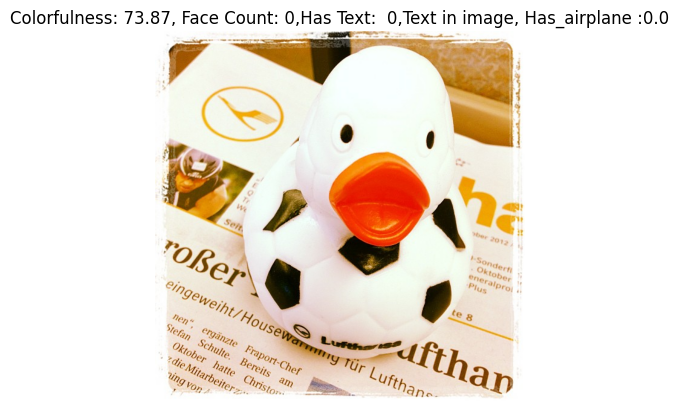

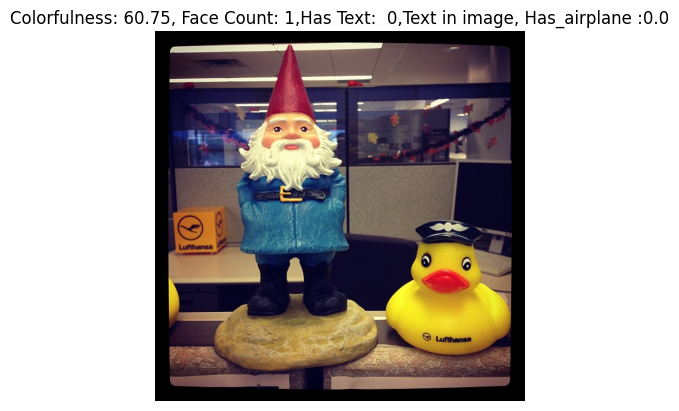

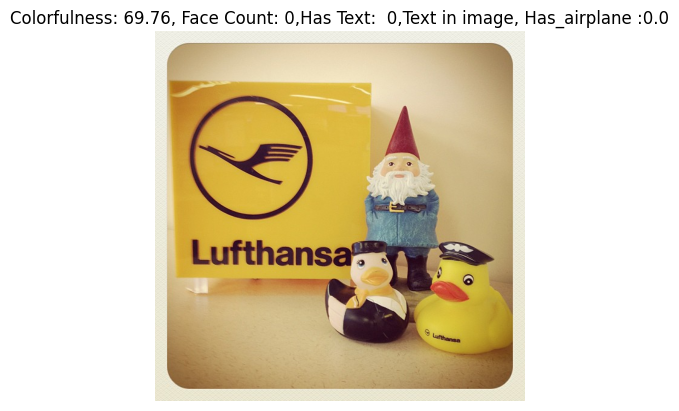

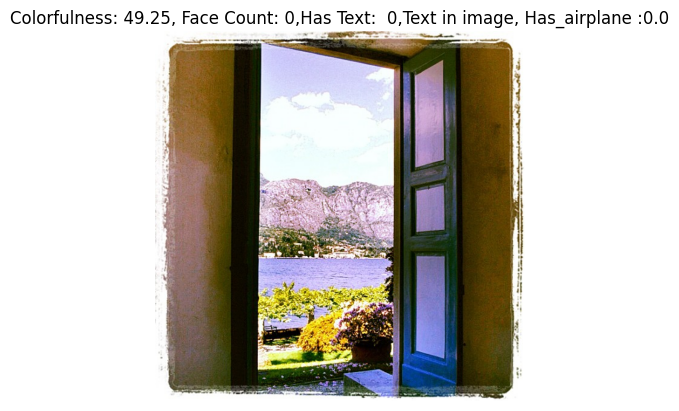

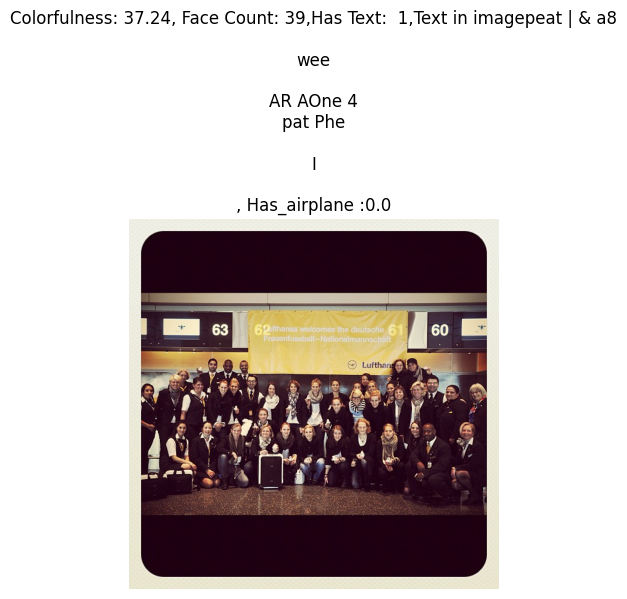

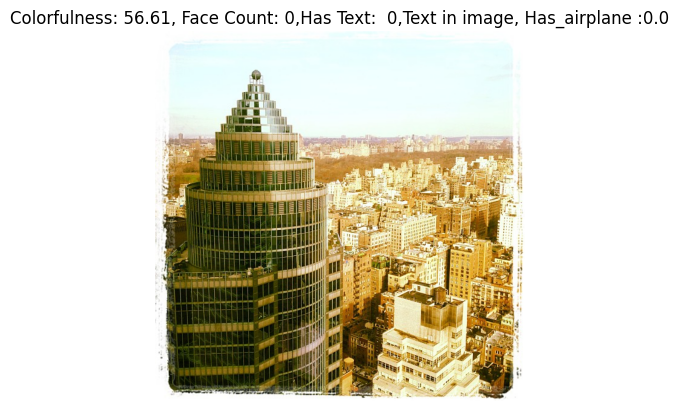

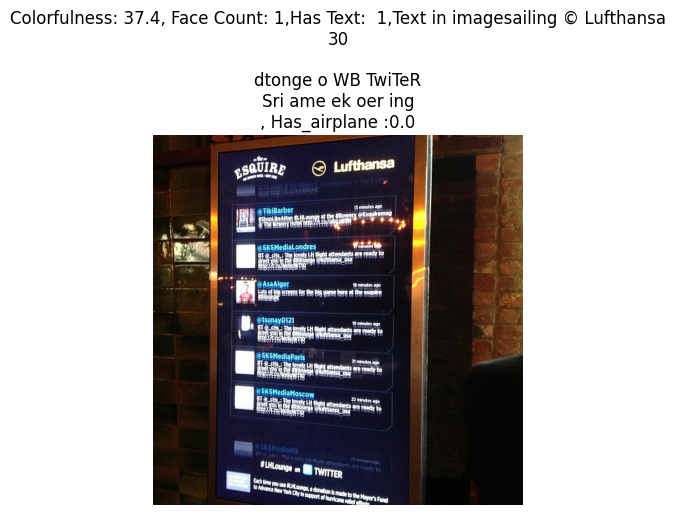

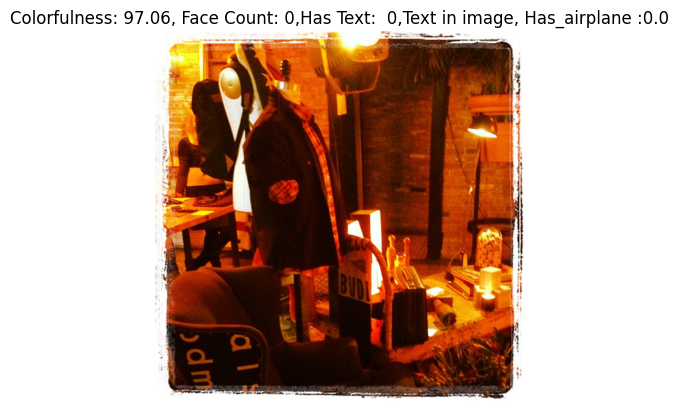

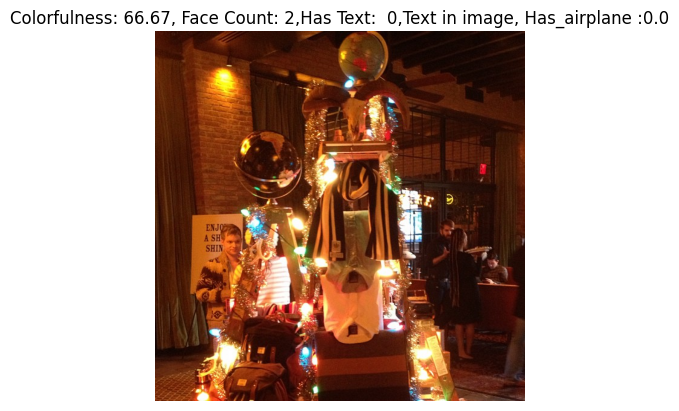

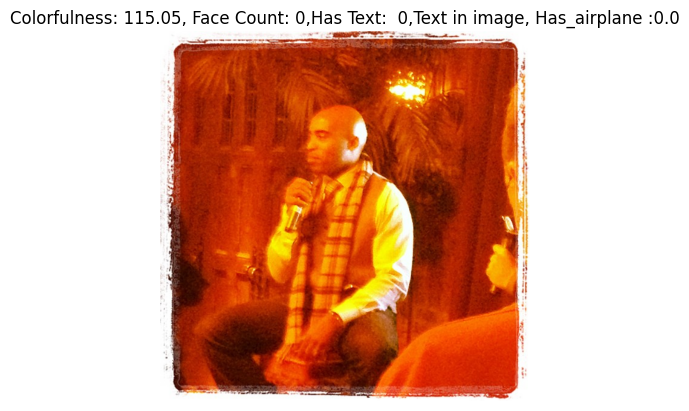

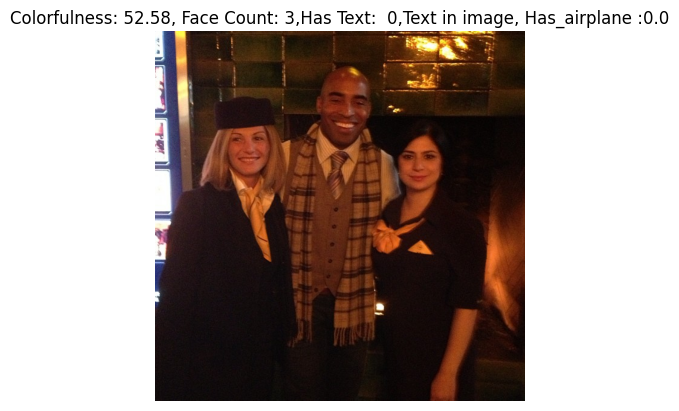

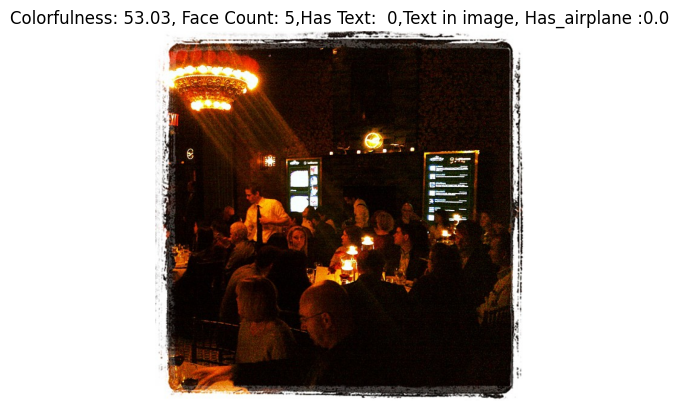

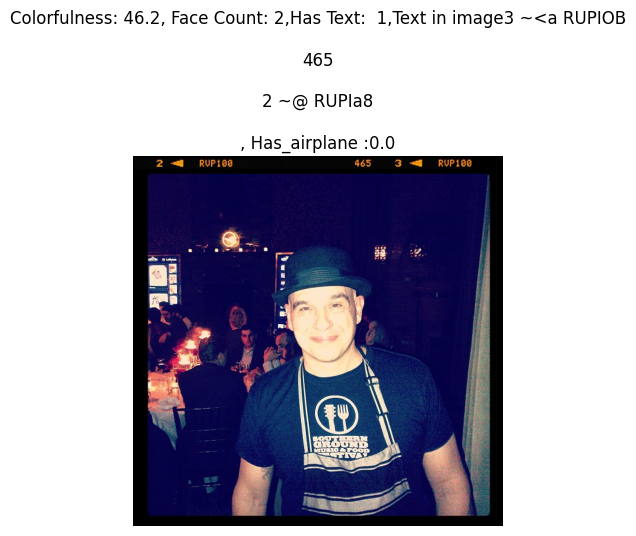

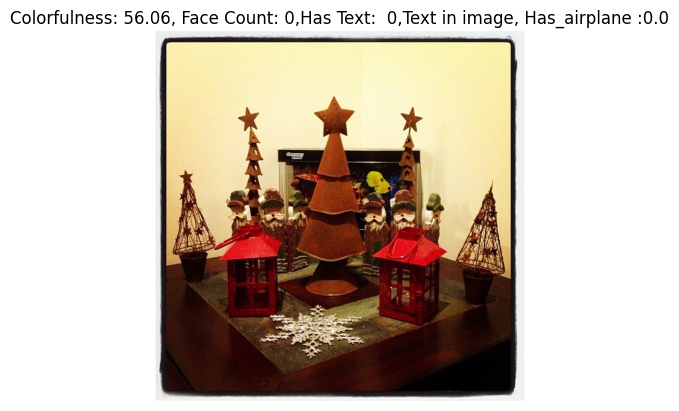

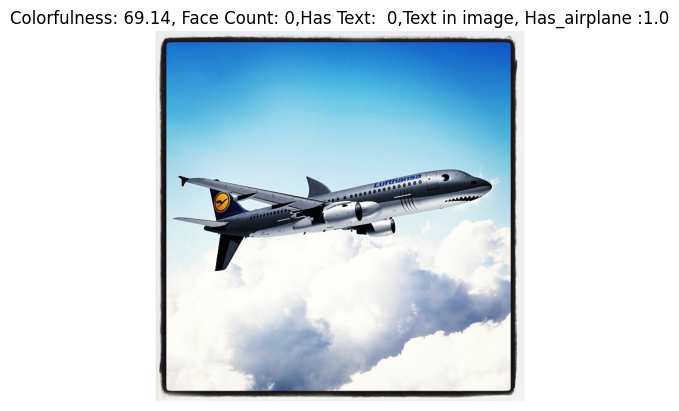

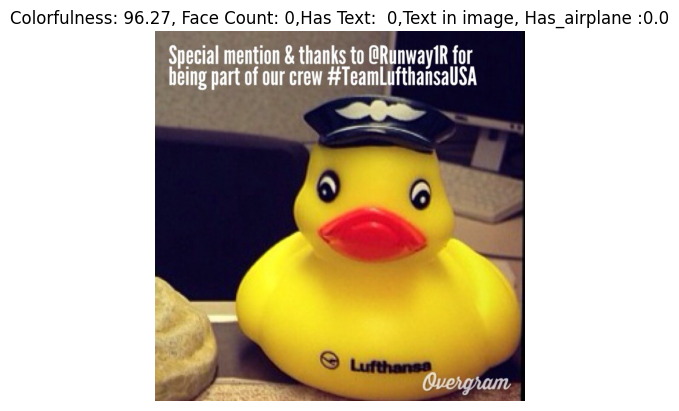

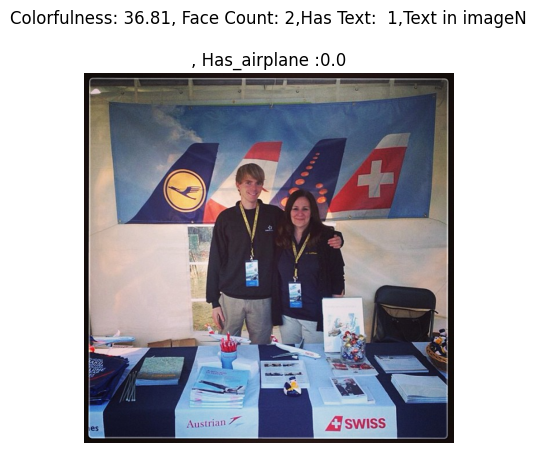

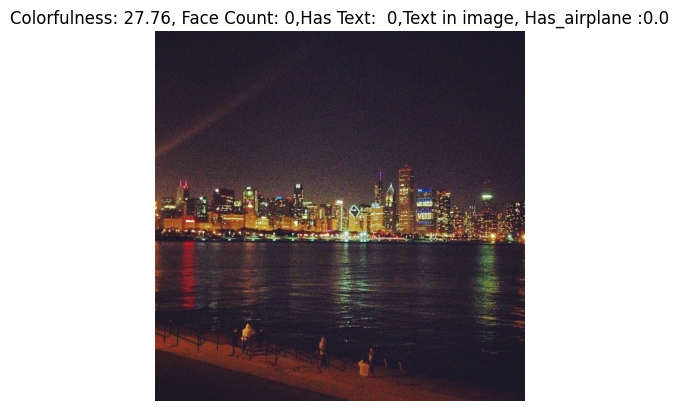

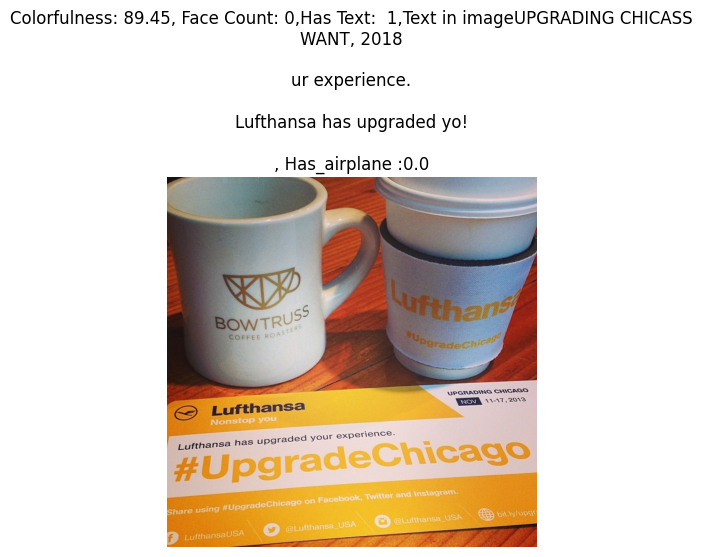

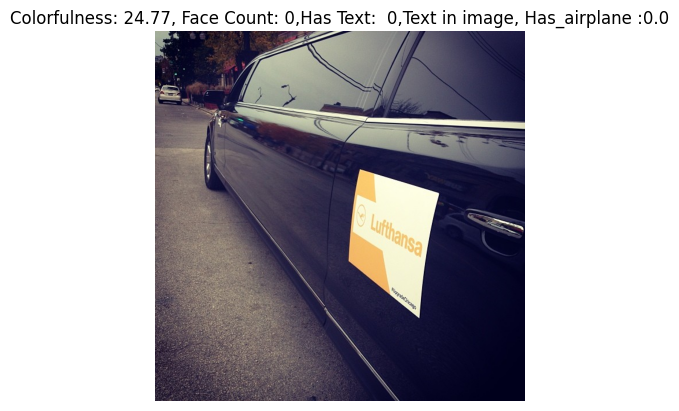

In [30]:
# Display features related to images
text_detection= True 
if text_detection: 
    # Number of images to display
    x = 20  # You can change this number as needed

    # Retrieve the first x rows of the DataFrame
    first_x_rows = pic_df_luf.limit(x).collect()

    # Function to display images
    def display_images(rows):
        for row in rows:
            image_path = row['path']
            colorfulness_score = row['colorfulness']
            face_count = row['face_count']
            text_in_image = row['text_in_image']
            photo_has_text= row["photo_has_text"]
            has_airplane = row['has_airplane']

            # Load the image
            image = cv2.imread(image_path)
            if image is None:
                print(f"Failed to load image at {image_path}")
                continue

            # Convert the image to RGB
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Display the image along with colorfulness and face count
            plt.imshow(image_rgb)
            plt.title(f"Colorfulness: {colorfulness_score}, Face Count: {face_count},Has Text:  {photo_has_text},Text in image{text_in_image}, Has_airplane :{has_airplane}")
            plt.axis("off")
            plt.show()

    # Display the images
    display_images(first_x_rows)


else: 

    # Number of images to display
    x = 20  # You can change this number as needed

    # Retrieve the first x rows of the DataFrame
    first_x_rows = pic_df_luf.limit(x).collect()

    # Function to display images
    def display_images(rows):
        for row in rows:
            image_path = row['path']
            colorfulness_score = row['colorfulness']
            face_count = row['face_count']
            
            has_airplane = row['has_airplane']

            # Load the image
            image = cv2.imread(image_path)
            if image is None:
                print(f"Failed to load image at {image_path}")
                continue

            # Convert the image to RGB
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            # Display the image along with colorfulness and face count
            plt.imshow(image_rgb)
            plt.title(f"Colorfulness: {colorfulness_score}, Face Count: {face_count}, Has_airplane :{has_airplane}")
            plt.axis("off")
            plt.show()

    # Display the images
    display_images(first_x_rows)

In [31]:
# Drop the variable text_in_image because the results appear non-sensical
pic_df_luf= pic_df_luf.drop("text_in_image")

#### 3.4.5. Label Detection 

In [6]:
# See other notebook (../additional_data/logo_prediction.ipynb) to see how it is constructed 
# Load the csv file related to the logos. 
logo_prediction_path= "../additional_data/logo_prediction_combined.csv"
schema = StructType([
    StructField("path", StringType(), True),
    StructField("Description", StringType(), True),
    StructField("Confidence", DoubleType(), True),
    StructField("name", StringType(), True)
])

logo_df = spark.read.csv(logo_prediction_path, header=True, schema=schema,sep=",")
logo_df= logo_df.drop("path")
logo_df.show(5,truncate=False)

+-----------+------------------+---------------------------+
|Description|Confidence        |name                       |
+-----------+------------------+---------------------------+
|Lufthansa  |0.7830049991607666|2012-10-11_17-21-43_UTC.jpg|
|Lufthansa  |0.9431076645851136|2012-10-11_17-24-02_UTC.jpg|
|Lufthansa  |0.9701882600784302|2012-10-17_15-36-02_UTC.jpg|
|Lufthansa  |0.8783769607543945|2012-12-02_17-37-19_UTC.jpg|
|Lufthansa  |0.9681037068367004|2013-10-19_13-12-51_UTC.jpg|
+-----------+------------------+---------------------------+
only showing top 5 rows



In [11]:
# Left join with pic_combined_df
pic_combined_df_final= pic_df_luf.join(logo_df, on="name", how="left")
pic_combined_df_final = pic_combined_df_final.withColumn("has_brand_logo", F.when(F.col("Description").isNotNull(), F.lit(1)).otherwise(F.lit(0)))
pic_combined_df_final= pic_combined_df_final.drop("Description", "Confidence")

In [12]:
# Some instagram posts have more than 1 picture related to it, 
# however we argue that the first picture draws the most attention and thus has the highest influence 
# on customer engagement. 

# If there are multiple photos related to a post, it looks like this: 
# xxxx-xx-xx_xx-xx-xx_UTC_n with n representing the nth photo

# Filter the DataFrame to remove rows with numbers other than 1 after "UTC" in the 'name' column
filtered_df = pic_combined_df_final.filter(
    ~(
        (col("name").rlike("UTC_\\d+") & (F.regexp_extract(col("name"), "UTC_(\\d+)", 1) != "1")) |
        ~col("name").rlike("UTC")
    )
)
# Replace underscore followed by "1" with just UTC
filtered_df = filtered_df.withColumn("name", regexp_replace(col("name"), "UTC_1", "UTC"))

# Show the resulting DataFrame
filtered_df.show()
filtered_df.count()


+--------------------+------------+----------+--------------+------------+--------------+
|                name|colorfulness|face_count|photo_has_text|has_airplane|has_brand_logo|
+--------------------+------------+----------+--------------+------------+--------------+
|2012-10-11_17-21-...|       73.87|         0|             0|         0.0|             1|
|2012-10-11_17-24-...|       60.75|         1|             0|         0.0|             1|
|2012-10-17_15-36-...|       69.76|         0|             0|         0.0|             1|
|2012-10-23_21-02-...|       49.25|         0|             0|         0.0|             0|
|2012-10-25_14-27-...|       37.24|        39|             1|         0.0|             0|
|2012-11-28_15-13-...|       56.61|         0|             0|         0.0|             0|
|2012-12-02_17-37-...|        37.4|         1|             1|         0.0|             1|
|2012-12-02_17-57-...|       97.06|         0|             0|         0.0|             0|
|2012-12-0

1882

In [39]:
# Convert the PySpark DataFrame to a Pandas DataFrame
pandas_df = filtered_df.toPandas()

# Specify the path where you want to save the CSV file
output_path = "../processed_data/lufthansa/basetable_pictures_luf_brand.csv"

# Save the Pandas DataFrame to a CSV file
pandas_df.to_csv(output_path, index=False)

### 3.5. Additional features

In [91]:
# Create temporary basetable to engineer further features
basetable = text_df_luf.join(other=likes_df_luf, on="post_id", how="inner")\
                        .join(other= comment_df_luf, on= "post_id", how="inner").cache()

In [92]:
# Add date properties to basetable
basetable = basetable.withColumn("date", F.to_date(F.col("post_id").substr(1, 10), "yyyy-MM-dd")).alias("date") \
                   .withColumn("timestamp", expr("to_timestamp(substring(post_id, 1, 19), 'yyyy-MM-dd_HH-mm-ss')").cast("timestamp"))\
                   .withColumn("Month", month("timestamp")).cache()

#### 3.5.1. Time a brand post is the top post

In [93]:
window_spec = Window().orderBy(F.col("date"))
# Use the lead function to get the date of the next post
next_post_date = F.lead("date").over(window_spec)

# Calculate the time difference between each post and the next post
basetable = basetable.withColumn("time_top_post", F.when(next_post_date.isNotNull(), F.datediff(next_post_date, "date")).otherwise(None))

# Order the dataframe chronologically
time_top_post = basetable.select("post_id", "time_top_post").orderBy("date") 

# Show the top 20 rows
time_top_post.show(20)

+--------------------+-------------+
|             post_id|time_top_post|
+--------------------+-------------+
|2012-10-11_17-24-...|            0|
|2012-10-11_17-21-...|            6|
|2012-10-17_15-36-...|            8|
|2012-10-25_14-27-...|           34|
|2012-11-28_15-13-...|            4|
|2012-12-02_20-02-...|            2|
|2012-12-04_03-52-...|          150|
|2013-05-03_22-40-...|          169|
|2013-10-19_13-12-...|           23|
|2013-11-11_15-04-...|            0|
|2013-11-11_17-01-...|            0|
|2013-11-11_03-25-...|            1|
|2013-11-12_01-13-...|            0|
|2013-11-12_18-17-...|            0|
|2013-11-12_14-14-...|            1|
|2013-11-13_17-48-...|            0|
|2013-11-13_14-50-...|            1|
|2013-11-14_01-57-...|            1|
|2013-11-15_22-30-...|            2|
|2013-11-17_15-45-...|           19|
+--------------------+-------------+
only showing top 20 rows



#### 3.5.2. Post is weekday

In [94]:
# Add a boolean column to check if the post was posted on a weekday (according to paper De Vries et al)
basetable = basetable.withColumn("is_weekday", (F.dayofweek("date").between(2, 6)).cast(BooleanType()))

# Order the dataframe chronologically and drop date
week_day = basetable.select("post_id", "is_weekday").orderBy("date")

# Display results
week_day.show(20)

+--------------------+----------+
|             post_id|is_weekday|
+--------------------+----------+
|2012-10-11_17-24-...|      true|
|2012-10-11_17-21-...|      true|
|2012-10-17_15-36-...|      true|
|2012-10-25_14-27-...|      true|
|2012-11-28_15-13-...|      true|
|2012-12-02_20-02-...|     false|
|2012-12-04_03-52-...|      true|
|2013-05-03_22-40-...|      true|
|2013-10-19_13-12-...|     false|
|2013-11-11_03-25-...|      true|
|2013-11-11_17-01-...|      true|
|2013-11-11_15-04-...|      true|
|2013-11-12_14-14-...|      true|
|2013-11-12_01-13-...|      true|
|2013-11-12_18-17-...|      true|
|2013-11-13_17-48-...|      true|
|2013-11-13_14-50-...|      true|
|2013-11-14_01-57-...|      true|
|2013-11-15_22-30-...|      true|
|2013-11-17_15-45-...|     false|
+--------------------+----------+
only showing top 20 rows



#### 3.5.3. Part of Day

In [95]:
basetable = basetable.withColumn(
    "part_of_day",
    when((hour("timestamp") >= 0) & (hour("timestamp") < 6), "Night")
    .when((hour("timestamp") >= 6) & (hour("timestamp") < 12), "Morning")
    .when((hour("timestamp") >= 12) & (hour("timestamp") < 18), "Afternoon")
    .otherwise("Evening")
)

# Order the dataframe chronologically
part_day_df = basetable.select("post_id", "part_of_day").orderBy("date") 

# Display results
part_day_df.show()

+--------------------+-----------+
|             post_id|part_of_day|
+--------------------+-----------+
|2012-10-11_17-24-...|  Afternoon|
|2012-10-11_17-21-...|  Afternoon|
|2012-10-17_15-36-...|  Afternoon|
|2012-10-25_14-27-...|  Afternoon|
|2012-11-28_15-13-...|  Afternoon|
|2012-12-02_20-02-...|    Evening|
|2012-12-04_03-52-...|      Night|
|2013-05-03_22-40-...|    Evening|
|2013-10-19_13-12-...|  Afternoon|
|2013-11-11_03-25-...|      Night|
|2013-11-11_17-01-...|  Afternoon|
|2013-11-11_15-04-...|  Afternoon|
|2013-11-12_14-14-...|  Afternoon|
|2013-11-12_18-17-...|    Evening|
|2013-11-12_01-13-...|      Night|
|2013-11-13_14-50-...|  Afternoon|
|2013-11-13_17-48-...|  Afternoon|
|2013-11-14_01-57-...|      Night|
|2013-11-15_22-30-...|    Evening|
|2013-11-17_15-45-...|  Afternoon|
+--------------------+-----------+
only showing top 20 rows



#### 3.5.4. Season

In [96]:
# Add a new column 'Season' based on the adjusted start dates
basetable = basetable.withColumn(
    "season",
    when(
        ((col("Month") == 3) & (expr("day(timestamp)") >= 21)) | ((col("Month") > 3) & (col("Month") < 6)),
        "Spring"
    )
    .when(
        ((col("Month") == 6) & (expr("day(timestamp)") >= 21)) | ((col("Month") > 6) & (col("Month") < 9)),
        "Summer"
    )
    .when(
        ((col("Month") == 9) & (expr("day(timestamp)") >= 21)) | ((col("Month") > 9) & (col("Month") < 12)),
        "Fall"
    )
    .otherwise("Winter")
)

# Order the dataframe chronologically and drop date
season_df = basetable.orderBy("date").select("post_id", "season")

# Display results
season_df.show()

+--------------------+------+
|             post_id|season|
+--------------------+------+
|2012-10-11_17-24-...|  Fall|
|2012-10-11_17-21-...|  Fall|
|2012-10-17_15-36-...|  Fall|
|2012-10-25_14-27-...|  Fall|
|2012-11-28_15-13-...|  Fall|
|2012-12-02_20-02-...|Winter|
|2012-12-04_03-52-...|Winter|
|2013-05-03_22-40-...|Spring|
|2013-10-19_13-12-...|  Fall|
|2013-11-11_03-25-...|  Fall|
|2013-11-11_17-01-...|  Fall|
|2013-11-11_15-04-...|  Fall|
|2013-11-12_14-14-...|  Fall|
|2013-11-12_01-13-...|  Fall|
|2013-11-12_18-17-...|  Fall|
|2013-11-13_17-48-...|  Fall|
|2013-11-13_14-50-...|  Fall|
|2013-11-14_01-57-...|  Fall|
|2013-11-15_22-30-...|  Fall|
|2013-11-17_15-45-...|  Fall|
+--------------------+------+
only showing top 20 rows



#### 3.4.5. Vividness

In [97]:
# Create vividness measure (according to paper L. De Vries et al.)
basetable = basetable.withColumn("vividness", 
    F.when(F.col("video") == "1", "High") \
    .when((F.col("video") == "0") & (F.col("is_event") == False), "Low") \
    .otherwise("Medium")) 

vididness_df = basetable.select("post_id", "vividness").show(20)

+--------------------+---------+
|             post_id|vividness|
+--------------------+---------+
|2020-03-25_15-10-...|      Low|
|2017-03-03_22-49-...|      Low|
|2017-03-06_16-38-...|      Low|
|2017-02-27_20-32-...|      Low|
|2020-04-08_15-37-...|      Low|
|2017-02-27_20-35-...|      Low|
|2015-04-02_15-20-...|      Low|
|2020-07-29_13-39-...|      Low|
|2020-04-06_14-56-...|     High|
|2017-03-03_22-45-...|      Low|
|2015-09-26_06-44-...|      Low|
|2017-03-02_16-37-...|      Low|
|2017-03-02_16-36-...|      Low|
|2017-03-03_22-38-...|      Low|
|2017-03-01_15-52-...|      Low|
|2020-04-16_12-49-...|      Low|
|2017-02-23_15-42-...|      Low|
|2017-03-05_21-10-...|      Low|
|2016-05-24_17-17-...|     High|
|2017-03-05_21-27-...|      Low|
+--------------------+---------+
only showing top 20 rows



#### 3.4.6 Contains city

Let's first look for cities by joining the tokenized caption text with a city database and checking for matches

In [11]:
# Define the path to the CSV file
csv_file_path = "../data/worldcities.csv"

# Read the CSV file into a Spark DataFrame
cities_df = spark.read.csv(csv_file_path, header=True, inferSchema=True)

In [12]:
# Check content dataframe
cities_df.cache()
cities_df.show(5)

+---------+----------+-------+--------+---------+----+----+-----------+-------+----------+----------+
|     city|city_ascii|    lat|     lng|  country|iso2|iso3| admin_name|capital|population|        id|
+---------+----------+-------+--------+---------+----+----+-----------+-------+----------+----------+
|    Tokyo|     Tokyo|35.6897|139.6922|    Japan|  JP| JPN|      Tōkyō|primary|  3.7732E7|1392685764|
|  Jakarta|   Jakarta| -6.175|106.8275|Indonesia|  ID| IDN|    Jakarta|primary|  3.3756E7|1360771077|
|    Delhi|     Delhi|  28.61|   77.23|    India|  IN| IND|      Delhi|  admin|  3.2226E7|1356872604|
|Guangzhou| Guangzhou|  23.13|  113.26|    China|  CN| CHN|  Guangdong|  admin|   2.694E7|1156237133|
|   Mumbai|    Mumbai|19.0761| 72.8775|    India|  IN| IND|Mahārāshtra|  admin|  2.4973E7|1356226629|
+---------+----------+-------+--------+---------+----+----+-----------+-------+----------+----------+
only showing top 5 rows



In [13]:
# Select necessary columns
cities_df = cities_df.select("city")
cities_df.show(5) ## 44k cities

+---------+
|     city|
+---------+
|    Tokyo|
|  Jakarta|
|    Delhi|
|Guangzhou|
|   Mumbai|
+---------+
only showing top 5 rows



In [14]:
# Remove punctuation marks from the text column
basetable_cleaned = basetable.withColumn("cleaned_text", regexp_replace("text", "[^a-zA-Z0-9\\s]", ""))

# Tokenize the cleaned text column into words
basetable_tokenized = basetable_cleaned.withColumn("token", explode(expr("split(lower(cleaned_text), ' ')"))).drop("city")

# Join DataFrame with cities DataFrame
contains_city = basetable_tokenized.join(
    cities_df,
    expr("lower(token) = lower(city)"),
    "left_outer")\
    .withColumn("contains_city_joins", col("city").isNotNull().cast("boolean")) \
    .groupBy("post_id", "cleaned_text")\
    .agg(expr("max(contains_city_joins) as contains_city_joins"))\
    .select("post_id", "cleaned_text","contains_city_joins")

# Display result
contains_city.cache()
contains_city.show(5)

+--------------------+--------------------+-------------------+
|             post_id|        cleaned_text|contains_city_joins|
+--------------------+--------------------+-------------------+
|2013-10-19_13-12-...|Come visit Luftha...|              false|
|2013-11-12_01-13-...|Our afternoon was...|              false|
|2013-11-13_14-50-...|Todays morning up...|              false|
|2013-12-12_03-06-...|Flying over Miami...|               true|
|2014-01-13_15-22-...|A Boeing 7478 on ...|               true|
+--------------------+--------------------+-------------------+
only showing top 5 rows



In [15]:
contains_city.groupBy("contains_city_joins").count().orderBy("count",ascending=False).show()

+-------------------+-----+
|contains_city_joins|count|
+-------------------+-----+
|               true| 1013|
|              false|  748|
+-------------------+-----+



As can be seen below, this approach results in quite some false positives

In [16]:
contains_city.filter("contains_city_joins == TRUE").select("cleaned_text").show(10,truncate = False)

+----------------------------------------------------------------------------------------------------------------------+
|cleaned_text                                                                                                          |
+----------------------------------------------------------------------------------------------------------------------+
|Flying over Miami lufthansa Thanks to tndo for sharing\r\n                                                            |
|A Boeing 7478 on a snowy day at OHare lufthansa chicago Thanks to kribs1984 for sharing\r\n                           |
|What a cool shot of this 744 taxiing at San Francisco International lufthansa sfo Thanks to klasavgeek for sharing\r\n|
|throwbackthursday A shot of lufthansa uniforms past tbt\r\n                                                           |
|traveltuesday Beautiful Copenhagen Have you visited\r\n                                                               |
|A little bit of sun peeking thr

Let's add a second check, by using Named Entity Recognition (NER) to look for cities in the post captions. This is an NLP technique made specifically to identify certain entity types in texts, and thus perfect for our goal. We'll extract the GPE (GeoPolitical Entity) words from the text. Below, we provide 3 examples

In [17]:
## An example of the NER at work
displacy.render(NER(contains_city.select("cleaned_text").collect()[10]["cleaned_text"]), style="ent")
displacy.render(NER(contains_city.select("cleaned_text").collect()[28]["cleaned_text"]), style="ent")
displacy.render(NER(contains_city.select("cleaned_text").collect()[44]["cleaned_text"]), style="ent")

c:\Users\Matteo_Ballegeer\AppData\Local\Programs\Python\Python311\Lib\site-packages\spacy\displacy\__init__.py:213: UserWarning: [W006] No entities to visualize found in Doc object. If this is surprising to you, make sure the Doc was processed using a model that supports named entity recognition, and check the `doc.ents` property manually if necessary.
  warnings.warn(Warnings.W006)


As we're specifically checking for cities, not e.g. countries, our udf will look for a match with the city list specified above and only flag the text as True if a match between a GPE entity and this city list is found. 

In [18]:
city_list = cities_df.select("city").rdd.flatMap(lambda x: x).collect()
contains_city = contains_city.withColumn("contains_city_NER", 
                                                 F.udf(lambda text: NER_city(text, city_list), 
                                                       returnType=BooleanType())("cleaned_text")).cache()

In [19]:
contains_city.groupBy("contains_city_NER").count().orderBy("count",ascending=True).show()

+-----------------+-----+
|contains_city_NER|count|
+-----------------+-----+
|             true|  348|
|            false| 1413|
+-----------------+-----+



Finally, let's take the intersect of the two methods to ensure the feature's quality

In [20]:
contains_city = contains_city.withColumn("contains_city",
                                                 F.when((F.col("contains_city_joins") == True) & (F.col("contains_city_NER") == True), True)
                                                 .otherwise(False))
contains_city.show(5)

+--------------------+--------------------+-------------------+-----------------+-------------+
|             post_id|        cleaned_text|contains_city_joins|contains_city_NER|contains_city|
+--------------------+--------------------+-------------------+-----------------+-------------+
|2013-10-19_13-12-...|Come visit Luftha...|              false|            false|        false|
|2013-11-12_01-13-...|Our afternoon was...|              false|            false|        false|
|2013-11-13_14-50-...|Todays morning up...|              false|            false|        false|
|2013-12-12_03-06-...|Flying over Miami...|               true|             true|         true|
|2014-01-13_15-22-...|A Boeing 7478 on ...|               true|            false|        false|
+--------------------+--------------------+-------------------+-----------------+-------------+
only showing top 5 rows



In [21]:
contains_city.groupBy("contains_city").count().orderBy("count",ascending=True).show()

+-------------+-----+
|contains_city|count|
+-------------+-----+
|         true|  331|
|        false| 1430|
+-------------+-----+



In [109]:
# Add the contains_city column to the basetable
basetable = basetable.join(contains_city.select("post_id", "contains_city"), on="post_id", how="left")
# Show the resulting DataFrame
basetable.select("post_id","text","contains_city").show(5)

+--------------------+--------------------+-------------+
|             post_id|                text|contains_city|
+--------------------+--------------------+-------------+
|2013-10-19_13-12-...|Come visit #Lufth...|        false|
|2013-11-11_15-04-...|We're starting th...|         true|
|2013-11-11_17-01-...|Today in #Chicago...|         true|
|2013-11-11_03-25-...|We’re in #Chicago...|         true|
|2013-11-12_01-13-...|Our afternoon was...|        false|
+--------------------+--------------------+-------------+
only showing top 5 rows



#### 3.4.7. Aspect ratio

In [100]:
# Define aspect ratio: square, portrait and landscape (according to website http://www.theverge.com/2015/9/27/9398551/instagram-portrait-photos-rule)(2015))

# Define conditions
conditions = [
    (col("aspect_ratio") >= 0.95) & (col("aspect_ratio") <= 1.05),  # Square
    (col("aspect_ratio") < 0.95),  # Portrait
    (col("aspect_ratio") > 1.05)   # Landscape 
]

# Define corresponding categories
categories = ["square", "portrait", "landscape"]

# Create a new column "aspect_ratio_category" based on conditions
basetable = basetable.withColumn("aspect_ratio_category", when(conditions[0], categories[0])
                                                         .when(conditions[1], categories[1])
                                                         .when(conditions[2], categories[2])
                                                         .otherwise("other")) 
aspect_df = basetable.select("post_id", "aspect_ratio_category") 

# Show the DataFrame
aspect_df.show()

+--------------------+---------------------+
|             post_id|aspect_ratio_category|
+--------------------+---------------------+
|2020-03-25_15-10-...|               square|
|2017-03-03_22-49-...|            landscape|
|2017-03-06_16-38-...|               square|
|2017-02-27_20-32-...|             portrait|
|2020-04-08_15-37-...|               square|
|2017-02-27_20-35-...|             portrait|
|2015-04-02_15-20-...|               square|
|2020-07-29_13-39-...|               square|
|2020-04-06_14-56-...|            landscape|
|2017-03-03_22-45-...|            landscape|
|2015-09-26_06-44-...|               square|
|2017-03-02_16-37-...|            landscape|
|2017-03-02_16-36-...|            landscape|
|2017-03-03_22-38-...|               square|
|2017-03-01_15-52-...|            landscape|
|2020-04-16_12-49-...|               square|
|2017-02-23_15-42-...|               square|
|2017-03-05_21-10-...|            landscape|
|2016-05-24_17-17-...|            landscape|
|2017-03-0

## 4. Loading Data

#### 4.1. Loading pictures data

In [9]:
# Load the csv file related to the pictures
pic_df_luf_path=  "../processed_data/lufthansa/basetable_pictures_luf_brand.csv"
schema = StructType([
    StructField("name", StringType(), True),
    StructField("path", StringType(), True),
    StructField("colorfulness", FloatType(), True),
    StructField("face_count", IntegerType(), True),
    StructField("photo_has_text", IntegerType(),True),
    StructField("has_airplane", FloatType(), True),
    StructField("has_brand_logo", IntegerType(), True)
])

pic_df_luf = spark.read.csv(pic_df_luf_path, header=True, schema=schema,sep=",")
pic_df_luf= pic_df_luf.drop("path")
pic_df_luf.show()

+--------------------+------------+----------+--------------+------------+--------------+
|                name|colorfulness|face_count|photo_has_text|has_airplane|has_brand_logo|
+--------------------+------------+----------+--------------+------------+--------------+
|2012-10-11_17-21-...|       73.87|         0|             0|         0.0|             1|
|2012-10-11_17-24-...|       60.75|         1|             0|         0.0|             1|
|2012-10-17_15-36-...|       69.76|         0|             0|         0.0|             1|
|2012-10-23_21-02-...|       49.25|         0|             0|         0.0|             0|
|2012-10-25_14-27-...|       37.24|        39|             1|         0.0|             0|
|2012-11-28_15-13-...|       56.61|         0|             0|         0.0|             0|
|2012-12-02_17-37-...|        37.4|         1|             1|         0.0|             1|
|2012-12-02_17-57-...|       97.06|         0|             0|         0.0|             0|
|2012-12-0

In [7]:
# Create new column 
pic_df_luf = pic_df_luf.withColumn("post_id", expr("SUBSTRING(name, 1, LENGTH(name)-4)"))\
                        .drop("name")
pic_df_luf.show(truncate= False)

+------------+----------+--------------+------------+--------------+-----------------------+
|colorfulness|face_count|photo_has_text|has_airplane|has_brand_logo|post_id                |
+------------+----------+--------------+------------+--------------+-----------------------+
|73.87       |0         |0             |0.0         |1             |2012-10-11_17-21-43_UTC|
|60.75       |1         |0             |0.0         |1             |2012-10-11_17-24-02_UTC|
|69.76       |0         |0             |0.0         |1             |2012-10-17_15-36-02_UTC|
|49.25       |0         |0             |0.0         |0             |2012-10-23_21-02-50_UTC|
|37.24       |39        |1             |0.0         |0             |2012-10-25_14-27-28_UTC|
|56.61       |0         |0             |0.0         |0             |2012-11-28_15-13-52_UTC|
|37.4        |1         |1             |0.0         |1             |2012-12-02_17-37-19_UTC|
|97.06       |0         |0             |0.0         |0             |20

#### 4.2. Loading followers data

In [8]:
# Read in followers data 
followers_luf = pd.read_csv("../additional_data/lufthansa_follower_interpolation.csv")
followers_luf['date'] = pd.to_datetime(followers_luf['date'], format='%Y-%m-%d')
followers_luf

date  num_followers
0    2013-06-01              0
1    2013-06-02             55
2    2013-06-03            110
3    2013-06-04            166
4    2013-06-05            221
...         ...            ...
2767 2020-12-28        1414194
2768 2020-12-29        1414181
2769 2020-12-30        1414168
2770 2020-12-31        1414156
2771 2021-01-01        1414143

[2772 rows x 2 columns]

In [9]:
# Convert followers df to spark df
followers_luf_spark = spark.createDataFrame(followers_luf)

# Merge on date to get num_followers for each row
basetable = basetable.join(followers_luf_spark, on="date", how="left_outer")

# Remove the date column
basetable = basetable.drop("date")\
.drop("timestamp") \
.drop("month") \
.cache()

# Display basetable
basetable.show()

NameError: name 'basetable' is not defined

## 5. Creating final basetable and saving to .csv

In [104]:
# Join basetable with pic_df_luf
basetable = basetable.join(other= pic_df_luf, on="post_id", how="left").cache()

In [ ]:
# Type conversion such that missing values can be checked. 
basetable_copy = basetable.withColumn("num_words", F.col("num_words").cast(DoubleType())) \
                    .withColumn("num_hashtags", F.col("num_hashtags").cast(DoubleType())) \
                    .withColumn("num_tags", F.col("num_tags").cast(DoubleType())) \
                    .withColumn("num_exclamation_marks", F.col("num_exclamation_marks").cast(DoubleType())) \
                    .withColumn("num_question_marks", F.col("num_question_marks").cast(DoubleType())) \
                    .withColumn("is_event", F.col("is_event").cast(StringType())) \
                    .withColumn("contains_link", F.col("contains_link").cast(StringType())) \
                    .withColumn("at_in_text", F.col("at_in_text").cast(DoubleType())) \
                    .withColumn("num_likes", F.col("num_likes").cast(DoubleType())) \
                    .withColumn("hour", F.col("hour").cast(DoubleType())) \
                    .withColumn("ad", F.col("ad").cast(DoubleType())) \
                    .withColumn("num_pictures", F.col("num_pictures").cast(DoubleType())) \
                    .withColumn("video", F.col("video").cast(DoubleType())) \
                    .withColumn("is_weekday", F.col("is_weekday").cast(StringType())) \
                    .withColumn("time_top_post", F.col("time_top_post").cast(DoubleType())) \
                    .withColumn("contains_city", F.col("contains_city").cast(StringType())) \
                    .withColumn("location_cat", F.col("location_cat").cast(DoubleType()))\
                    .withColumn("num_comments", F.col("num_comments").cast(DoubleType()))\
                    .withColumn("colorfulness", F.col("colorfulness").cast(DoubleType()))\
                    .withColumn("face_count", F.col("face_count").cast(DoubleType()))\
                    .withColumn("photo_has_text", F.col("photo_has_text").cast(DoubleType()))\
                    .withColumn("has_airplane", F.col("has_airplane").cast(DoubleType()))\
                    .withColumn("has_brand_logo", F.col("has_brand_logo").cast(DoubleType()))\
                    .withColumn("nr_emojis", F.col("nr_emojis").cast(DoubleType()))

In [86]:
# Check missing values
# Columns to exclude from the check
exclude_columns = ["text", "text_tokenized_no_stops"]
for col_name in basetable_copy.columns:
    # Skip the columns in the exclusion list
    if col_name in exclude_columns:
        continue

    # Check for null, empty string, and NaN values
    missing_count = basetable_copy.filter(
        col(col_name).isNull() | (col(col_name) == "") | isnan(col(col_name))
    ).count()
    
    missing_percentage = (missing_count / basetable_copy.count()) * 100
    print(f"{col_name}: Missing Count = {missing_count}, Missing Percentage = {missing_percentage:.2f}%")

post_id: Missing Count = 0, Missing Percentage = 0.00%
num_words: Missing Count = 0, Missing Percentage = 0.00%
num_hashtags: Missing Count = 0, Missing Percentage = 0.00%
num_tags: Missing Count = 0, Missing Percentage = 0.00%
num_exclamation_marks: Missing Count = 0, Missing Percentage = 0.00%
num_question_marks: Missing Count = 0, Missing Percentage = 0.00%
is_event: Missing Count = 0, Missing Percentage = 0.00%
sentiment: Missing Count = 0, Missing Percentage = 0.00%
subjectivity: Missing Count = 0, Missing Percentage = 0.00%
contains_link: Missing Count = 0, Missing Percentage = 0.00%
at_in_text: Missing Count = 0, Missing Percentage = 0.00%
nr_emojis: Missing Count = 0, Missing Percentage = 0.00%
num_likes: Missing Count = 0, Missing Percentage = 0.00%
city: Missing Count = 1187, Missing Percentage = 67.06%
country: Missing Count = 1100, Missing Percentage = 62.15%
location: Missing Count = 1052, Missing Percentage = 59.44%
time: Missing Count = 0, Missing Percentage = 0.00%
hour

In [113]:
# Drop na_values
basetable = basetable.na.drop(subset=["time_top_post", "num_followers"])

In [114]:
# save basetable to csv file 
# Convert the PySpark DataFrame to a Pandas DataFrame
basetable_merged = basetable.toPandas()

# Specify the path where you want to save the CSV file
output_path = "../processed_data/lufthansa/merged_basetable_luf.csv"

# Save the Pandas DataFrame to a CSV file
basetable_merged.to_csv(output_path, index=False)

In [115]:
basetable_merged.head()

post_id                                               text  \
0  2013-10-19_13-12-51_UTC  Come visit #Lufthansa on Hospitality Row at #H...   
1  2013-11-11_15-04-10_UTC  We're starting the day by upgrading Chicagoans...   
2  2013-11-11_17-01-59_UTC  Today in #Chicago, we're upgrading your ride. ...   
3  2013-11-11_03-25-15_UTC  We’re in #Chicago gearing up for a big week. K...   
4  2013-11-12_01-13-07_UTC  Our afternoon was filled with heavy snow... An...   

                             text_tokenized_no_stops  num_words  num_hashtags  \
0  [come, visit, #lufthansa, hospitality, row, #h...         10             2   
1  [starting, day, upgrading, chicagoans, morning...         11             1   
2  [today, #chicago, upgrading, ride, hail, cab, ...         11             2   
3  [we’re, #chicago, gearing, big, week, keep, ey...         10             2   
4  [afternoon, filled, heavy, snow, handing, umbr...         10             1   

   num_tags  num_exclamation_marks  num_question_marks  is_event  sentiment  \
0         0                      0                   0     False     0.0000   
1         1                      1                   0     False     0.4926   
2         0                      0                   0     False     0.0772   
3         0                      1                   0     False     0.0000   
4         0                      0                   0     False     0.0000   

   ...  season  vividness  contains_city  aspect_ratio_category  \
0  ...    Fall        Low          False                 square   
1  ...    Fall        Low           True                 square   
2  ...    Fall        Low           True                 square   
3  ...    Fall        Low           True                 square   
4  ...    Fall        Low          False                 square   

   num_followers colorfulness face_count photo_has_text has_airplane  \
0          10575    36.810001          2              1          0.0   
1          13081    89.449997          0              1          0.0   
2          13081    24.770000          0              0          0.0   
3          13081    27.760000          0              0          0.0   
4          13190    34.889999          1              0          0.0   

   has_brand_logo  
0               1  
1               1  
2               1  
3               0  
4               0  

[5 rows x 41 columns]

In [108]:
basetable.printSchema()

root
 |-- post_id: string (nullable = false)
 |-- text: string (nullable = true)
 |-- text_tokenized_no_stops: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- num_words: integer (nullable = false)
 |-- num_hashtags: integer (nullable = true)
 |-- num_tags: integer (nullable = true)
 |-- num_exclamation_marks: integer (nullable = true)
 |-- num_question_marks: integer (nullable = true)
 |-- is_event: boolean (nullable = true)
 |-- sentiment: double (nullable = true)
 |-- subjectivity: double (nullable = true)
 |-- contains_link: boolean (nullable = true)
 |-- at_in_text: integer (nullable = true)
 |-- nr_emojis: integer (nullable = true)
 |-- num_likes: long (nullable = true)
 |-- city: string (nullable = true)
 |-- country: string (nullable = true)
 |-- location: string (nullable = true)
 |-- time: string (nullable = true)
 |-- hour: integer (nullable = true)
 |-- ad: integer (nullable = false)
 |-- num_pictures: integer (nullable = false)
 |-- video: integ

## 6. Load & inspect basetable

#### 6.1 Read-in basetable

In [9]:
# Read-in basetable

# Specify the path to the CSV file
csv_path = "../processed_data/lufthansa/merged_basetable_luf.csv"
pandas_df = pd.read_csv(csv_path, sep=",")

# Define the schema based on the provided column types
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, ArrayType, BooleanType, DoubleType, LongType, FloatType

schema = StructType([
    StructField("post_id", StringType(), nullable=False),
    StructField("text", StringType(), nullable=True),
    StructField("text_tokenized_no_stops", StringType(), nullable=True),
    StructField("num_words", IntegerType(), nullable=False),
    StructField("num_hashtags", IntegerType(), nullable=True),
    StructField("num_tags", IntegerType(), nullable=True),
    StructField("num_exclamation_marks", IntegerType(), nullable=True),
    StructField("num_question_marks", IntegerType(), nullable=True),
    StructField("is_event", BooleanType(), nullable=True),
    StructField("sentiment", DoubleType(), nullable=True),
    StructField("subjectivity", DoubleType(), nullable=True),
    StructField("contains_link", BooleanType(), nullable=True),
    StructField("at_in_text", IntegerType(), nullable=True),
    StructField("nr_emojis", IntegerType(), nullable=True),
    StructField("num_likes", LongType(), nullable=True),
    StructField("city", StringType(), nullable=True),
    StructField("country", StringType(), nullable=True),
    StructField("location", StringType(), nullable=True),
    StructField("time", StringType(), nullable=True),
    StructField("hour", IntegerType(), nullable=True),
    StructField("ad", IntegerType(), nullable=False),
    StructField("num_pictures", IntegerType(), nullable=True),
    StructField("video", IntegerType(), nullable=False),
    StructField("location_cat", IntegerType(), nullable=False),
    StructField("aspect_ratio", DoubleType(), nullable=True),
    StructField("city_bool", StringType(), nullable=True),
    StructField("country_bool", StringType(), nullable=True),
    StructField("num_comments", LongType(), nullable=True),
    StructField("time_top_post", IntegerType(), nullable=True),
    StructField("is_weekday", BooleanType(), nullable=True),
    StructField("part_of_day", StringType(), nullable=False),
    StructField("season", StringType(), nullable=False),
    StructField("vividness", StringType(), nullable=False),
    StructField("contains_city", BooleanType(), nullable=True),
    StructField("aspect_ratio_category", StringType(), nullable=True),
    StructField("num_followers", LongType(), nullable=True),
    StructField("colorfulness", FloatType(), nullable=True),
    StructField("face_count", IntegerType(), nullable=True),
    StructField("photo_has_text", IntegerType(), nullable=True),
    StructField("has_airplane", FloatType(), nullable=True),
    StructField("has_brand_logo", IntegerType(), nullable=True)
])

# Convert the modified Pandas DataFrame to a PySpark DataFrame
basetable = spark.createDataFrame(pandas_df, schema=schema)

# Re-Create the text_tokenized_no_stops column
basetable = basetable.withColumn("text_lower", F.lower("text")) \
                                 .withColumn("text_cleaned", remove_punct_UDF("text_lower")) \
                                 .withColumn("text_tokenized", F.split("text_cleaned", " ")) \
                                 .withColumn("text_tokenized_no_stops", remove_stops_UDF("text_tokenized")) \
                                 .drop("text_lower") \
                                 .drop("text_cleaned") \
                                 .drop("text_tokenized")

# Show the DataFrame schema and some sample data
basetable.printSchema()
basetable.cache()
basetable.show(5)

root
 |-- post_id: string (nullable = false)
 |-- text: string (nullable = true)
 |-- text_tokenized_no_stops: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- num_words: integer (nullable = false)
 |-- num_hashtags: integer (nullable = true)
 |-- num_tags: integer (nullable = true)
 |-- num_exclamation_marks: integer (nullable = true)
 |-- num_question_marks: integer (nullable = true)
 |-- is_event: boolean (nullable = true)
 |-- sentiment: double (nullable = true)
 |-- subjectivity: double (nullable = true)
 |-- contains_link: boolean (nullable = true)
 |-- at_in_text: integer (nullable = true)
 |-- nr_emojis: integer (nullable = true)
 |-- num_likes: long (nullable = true)
 |-- city: string (nullable = true)
 |-- country: string (nullable = true)
 |-- location: string (nullable = true)
 |-- time: string (nullable = true)
 |-- hour: integer (nullable = true)
 |-- ad: integer (nullable = false)
 |-- num_pictures: integer (nullable = true)
 |-- video: intege

#### 6.2. Convert values for model building

In [10]:
# Convert features to correct data type (for eventual model building)
basetable = basetable.withColumn("num_words", F.col("num_words").cast(DoubleType())) \
                    .withColumn("num_hashtags", F.col("num_hashtags").cast(DoubleType())) \
                    .withColumn("num_tags", F.col("num_tags").cast(DoubleType())) \
                    .withColumn("num_exclamation_marks", F.col("num_exclamation_marks").cast(DoubleType())) \
                    .withColumn("num_question_marks", F.col("num_question_marks").cast(DoubleType())) \
                    .withColumn("is_event", F.col("is_event").cast(StringType())) \
                    .withColumn("contains_link", F.col("contains_link").cast(StringType())) \
                    .withColumn("at_in_text", F.col("at_in_text").cast(DoubleType())) \
                    .withColumn("num_likes", F.col("num_likes").cast(DoubleType())) \
                    .withColumn("hour", F.col("hour").cast(DoubleType())) \
                    .withColumn("ad", F.col("ad").cast(DoubleType())) \
                    .withColumn("num_pictures", F.col("num_pictures").cast(DoubleType())) \
                    .withColumn("video", F.col("video").cast(DoubleType())) \
                    .withColumn("is_weekday", F.col("is_weekday").cast(StringType())) \
                    .withColumn("time_top_post", F.col("time_top_post").cast(DoubleType())) \
                    .withColumn("contains_city", F.col("contains_city").cast(StringType())) \
                    .withColumn("location_cat", F.col("location_cat").cast(DoubleType()))\
                    .withColumn("num_comments", F.col("num_comments").cast(DoubleType()))\
                    .withColumn("colorfulness", F.col("colorfulness").cast(DoubleType()))\
                    .withColumn("face_count", F.col("face_count").cast(DoubleType()))\
                    .withColumn("photo_has_text", F.col("photo_has_text").cast(DoubleType()))\
                    .withColumn("has_airplane", F.col("has_airplane").cast(DoubleType()))\
                    .withColumn("has_brand_logo", F.col("has_brand_logo").cast(DoubleType()))\
                    .withColumn("nr_emojis", F.col("nr_emojis").cast(DoubleType()))

#### 6.3. Check missing values

In [111]:
# Columns to exclude from the check
exclude_columns = ["text", "text_tokenized_no_stops"]
for col_name in basetable.columns:
    # Skip the columns in the exclusion list
    if col_name in exclude_columns:
        continue

    # Check for null, empty string, and NaN values
    missing_count = basetable.filter(
        col(col_name).isNull() | (col(col_name) == "") | isnan(col(col_name))
    ).count()
    
    missing_percentage = (missing_count / basetable.count()) * 100
    print(f"{col_name}: Missing Count = {missing_count}, Missing Percentage = {missing_percentage:.2f}%")

post_id: Missing Count = 0, Missing Percentage = 0.00%
num_words: Missing Count = 0, Missing Percentage = 0.00%
num_hashtags: Missing Count = 0, Missing Percentage = 0.00%
num_tags: Missing Count = 0, Missing Percentage = 0.00%
num_exclamation_marks: Missing Count = 0, Missing Percentage = 0.00%
num_question_marks: Missing Count = 0, Missing Percentage = 0.00%
is_event: Missing Count = 0, Missing Percentage = 0.00%
sentiment: Missing Count = 0, Missing Percentage = 0.00%
subjectivity: Missing Count = 0, Missing Percentage = 0.00%
contains_link: Missing Count = 0, Missing Percentage = 0.00%
at_in_text: Missing Count = 0, Missing Percentage = 0.00%
nr_emojis: Missing Count = 0, Missing Percentage = 0.00%
num_likes: Missing Count = 0, Missing Percentage = 0.00%
city: Missing Count = 1178, Missing Percentage = 66.89%
country: Missing Count = 1091, Missing Percentage = 61.95%
location: Missing Count = 1043, Missing Percentage = 59.23%
time: Missing Count = 0, Missing Percentage = 0.00%
hour